In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from wandb.keras import WandbCallback
from sklearn.preprocessing import MinMaxScaler
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.data as Data
from matplotlib import pyplot as plt
from torch.nn import functional
from tqdm import tqdm, notebook
import wandb
wandb.login()
device = "cpu"

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xmelicher (xmelicher-team). Use `wandb login --relogin` to force relogin


In [17]:
column_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
data = pd.read_csv('housing.csv', names=column_names,sep='\s+')
data[column_names]=data[column_names].astype('float32')

In [18]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float32
 1   ZN       506 non-null    float32
 2   INDUS    506 non-null    float32
 3   CHAS     506 non-null    float32
 4   NOX      506 non-null    float32
 5   RM       506 non-null    float32
 6   AGE      506 non-null    float32
 7   DIS      506 non-null    float32
 8   RAD      506 non-null    float32
 9   TAX      506 non-null    float32
 10  PTRATIO  506 non-null    float32
 11  B        506 non-null    float32
 12  LSTAT    506 non-null    float32
 13  MEDV     506 non-null    float32
dtypes: float32(14)
memory usage: 27.8 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.199997,4.0900,1.0,296.0,15.300000,396.899994,4.98,24.000000
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.900002,4.9671,2.0,242.0,17.799999,396.899994,9.14,21.600000
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.099998,4.9671,2.0,242.0,17.799999,392.829987,4.03,34.700001
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.799999,6.0622,3.0,222.0,18.700001,394.630005,2.94,33.400002
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.200001,6.0622,3.0,222.0,18.700001,396.899994,5.33,36.200001


There are 14 attributes in each case of the dataset. They are:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

<Axes: >

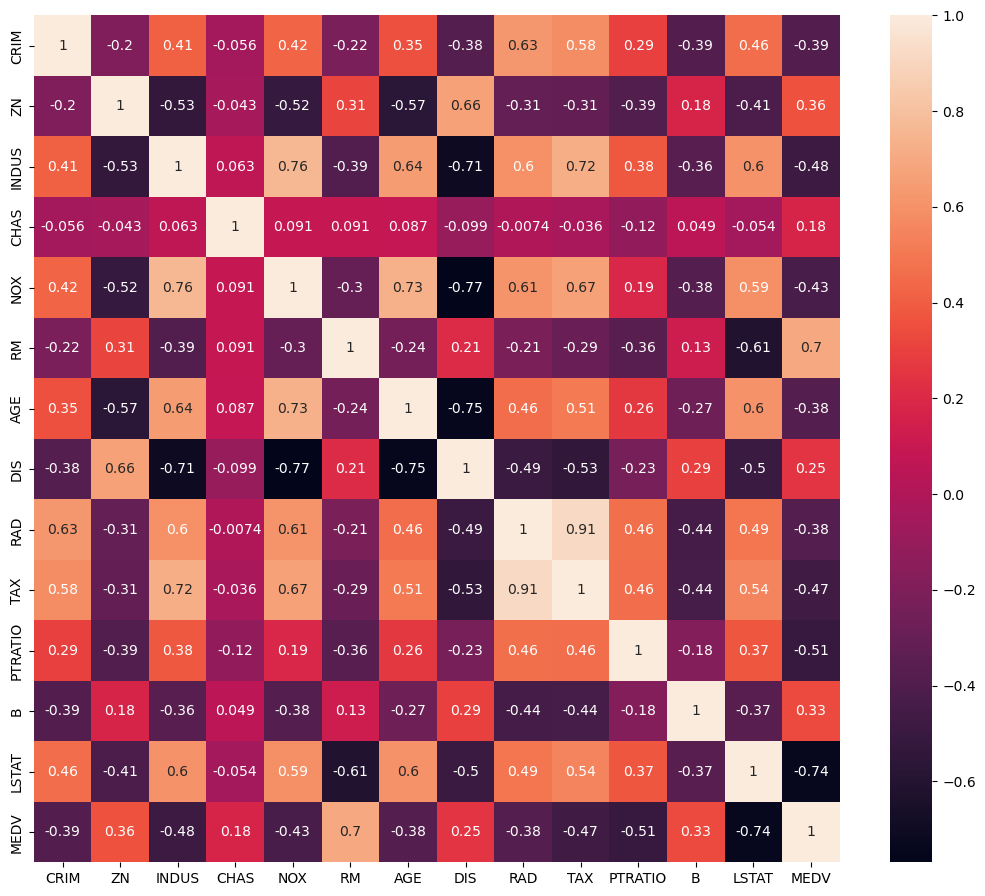

In [19]:
boston_df = pd.DataFrame(data, columns=column_names)
plt.figure(figsize=(13,11))
sns.heatmap(boston_df.corr(), annot=True)

Budeme predikovať atribút MEDV - Median value of owner-occupied homes in $1000's.
V tabuľke korelácii vidíme, že medzi atribútmi LSTAT, PTRATIO, INDUS, TAX , MEDV ,RM ,RAD existujú signifikantné korelácie.
Ostatné premenné korelujú v menej signifikantne.



<Axes: >

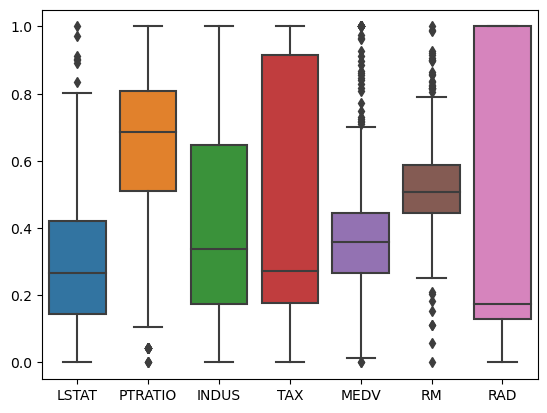

In [20]:
column_names = ["LSTAT", "PTRATIO", "INDUS", "TAX" , "MEDV" ,"RM" ,"RAD"]
new = boston_df.filter(column_names)

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(new), columns=column_names)
sns.boxplot(data=df_scaled)

Vidíme, že žiadna premenná neobashuje signifikantné množstvo outlierov, takže ich nieje potrebné nijako ošetrovať.

## Definície tried a train/test funkcií

In [21]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

maefn = torch.nn.L1Loss()
rmsefn = RMSELoss()

class Model(torch.nn.Module):
    def __init__(self, *args):
        super(Model, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(args[0], args[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(args[1], args[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(args[2], args[3]),
            torch.nn.ReLU(),
            torch.nn.Linear(args[3], 1),
        )

    def forward(self, input):
        x = self.flatten(input)
        logits = self.linear_relu_stack(x)
        return logits


def train(dataloader, model, loss_fn, optimizer):
    running_loss = 0.
    last_loss = 0.
    mae = 0.
    rmse = 0.

    model.train()
    for i, data in enumerate(dataloader):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        mae += maefn(outputs, labels).item()
        rmse += rmsefn(outputs, labels).item()
        

    last_loss = running_loss / len(dataloader.dataset)
    mae = mae / len(dataloader.dataset)
    rmse = rmse / len(dataloader.dataset)
    return rmse, mae, last_loss


def test(dataloader, model, loss_fn):

    model.eval()
    test_loss = 0.
    mae = 0.
    rmse = 0.
    
    with torch.no_grad():  # disable updating of gradients
        for i, data in enumerate(dataloader):
            inputs, labels = data
            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            mae += maefn(pred, labels).item()
            rmse += rmsefn(pred, labels).item()
            
    test_loss /= len(dataloader.dataset)
    
    print(f"Test loss: {test_loss:>8f} \r")
    mae = mae / len(dataloader.dataset)
    rmse = rmse / len(dataloader.dataset)
    return rmse, mae, test_loss


class DataMaker(Data.Dataset):
    def __init__(self, X, y):
        # scaler = StandardScaler()
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(X)
        self.labels = y
    
    def __getitem__(self, i):
        data = torch.from_numpy(np.asarray(self.data[i]))
        labels = torch.from_numpy(np.asarray(self.labels[i]))
        return data, labels

    def __len__(self):
        return len(self.labels)

## Korelácie v train/test dátach

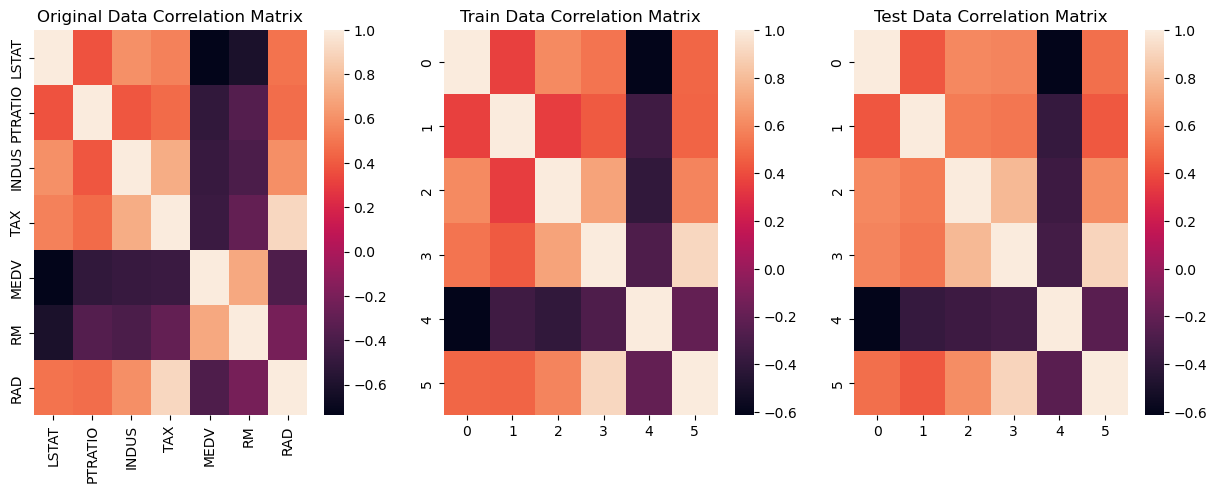

In [22]:
X = np.array(new.drop('MEDV', axis=1))
y = np.array(new['MEDV'])

# Spliting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the correlation matrix for your original dataset
corr_original = new.corr()

# Calculate the correlation matrix for your train set
corr_train = pd.DataFrame(X_train).corr()

# Calculate the correlation matrix for your test set
corr_test = pd.DataFrame(X_test).corr()

# Create a heatmap plot to compare the correlation matrices
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.heatmap(corr_original, ax=ax[0])
ax[0].set_title('Original Data Correlation Matrix')

sns.heatmap(corr_train, ax=ax[1])
ax[1].set_title('Train Data Correlation Matrix')

sns.heatmap(corr_test, ax=ax[2])
ax[2].set_title('Test Data Correlation Matrix')

plt.show()

Po rozdelení datasetu na trénovací a testovací overíme, či v daných vzorkách ostali podobné korelácie medzi atribútmi.

In [23]:
config = {
"EPOCHS": 250,
"BATCH_SIZE": 25,
"LEARNING_RATE": 0.001,
"Layer_sizes": [6, 128, 32, 10],
"beta_1":0.9,
"beta_2":0.999,
"momentum": 0.03,
"rho": 0.9,
"dropout": 0.5,
}


# TF model initialization
tf_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(config["Layer_sizes"][0],)),
    keras.layers.Dense(config["Layer_sizes"][1], activation=tf.nn.relu),
	keras.layers.Dense(config["Layer_sizes"][2], activation=tf.nn.relu),
	keras.layers.Dense(config["Layer_sizes"][3], activation=tf.nn.relu),
    keras.layers.Dense(1)
])
# TF model hyperparameters initialization
tf_model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=config["LEARNING_RATE"],
        beta_1=config["beta_1"],
        beta_2=config["beta_2"],
    ),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)

# Data processing -> train set and test set
train_set = DataMaker(X_train, y_train)
test_set = DataMaker(X_test, y_test)

train_loader = Data.DataLoader(train_set, shuffle=False, batch_size=config["BATCH_SIZE"])
test_loader = Data.DataLoader(test_set, shuffle=False, batch_size=config["BATCH_SIZE"])

# Torch model initialization
model = Model(*config["Layer_sizes"]).to(device)
# Torch model optimizer initialization
optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"], betas=(config["beta_1"], config["beta_2"]))

# Loss functions initialization
rmsefn = RMSELoss()

In [9]:
# Train TF model
run = wandb.init(project="zadanie1-pytorch", config=config, name="tf")
tf_model.fit(X_train, y_train, epochs=config["EPOCHS"], batch_size=config["BATCH_SIZE"], validation_data=(X_test, y_test), callbacks=[WandbCallback()])
run.finish()



# Train PyTorch model
run = wandb.init(project="zadanie1-pytorch", config=config, name="pytorch")
run.watch(model)

from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
best_vloss = 10000000

for epoch in range(config["EPOCHS"]):
    rmse, mae, train_loss = train(train_loader, model, lossfn, optimizer)
    val_rmse, val_mae, valid_loss = test(test_loader, model, lossfn)

    wandb.log({"val_loss": valid_loss, "loss": train_loss, "root_mean_squared_error": rmse,
               "val_root_mean_squared_error": val_rmse, "mean_absolute_error": mae, "val_mean_absolute_error": val_mae})

    if valid_loss < best_vloss:
        best_vloss = valid_loss
        model_path = 'models/model_{}_{}'.format(timestamp, epoch)
        #torch.save(model.state_dict(), model_path)

run.finish()


'\n# Train PyTorch model\nrun = wandb.init(project="zadanie1-pytorch", config=config, name="pytorch")\nrun.watch(model)\n\nfrom datetime import datetime\ntimestamp = datetime.now().strftime(\'%Y%m%d_%H%M%S\')\nbest_vloss = 10000000\n\nfor epoch in range(config["EPOCHS"]):\n    rmse, mae, train_loss = train(train_loader, model, lossfn, optimizer)\n    val_rmse, val_mae, valid_loss = test(test_loader, model, lossfn)\n\n    wandb.log({"val_loss": valid_loss, "loss": train_loss, "root_mean_squared_error": rmse,\n               "val_root_mean_squared_error": val_rmse, "mean_absolute_error": mae, "val_mean_absolute_error": val_mae})\n\n    if valid_loss < best_vloss:\n        best_vloss = valid_loss\n        model_path = \'models/model_{}_{}\'.format(timestamp, epoch)\n        #torch.save(model.state_dict(), model_path)\n\nrun.finish()\n'

## Gridsearch

In [10]:
from sklearn.model_selection import ParameterGrid
parameters = {
    "BATCH_SIZE": [25, 50, 100],
    "LEARNING_RATE": [0.001, 0.003, 0.01],
    "beta_1": [0.9, 0.8, 0.99],
    "beta_2": [0.999, 0.99, 0.9], 
}
for gr in ParameterGrid(parameters):
    config.update(gr)

    tf_model = keras.Sequential([
        keras.layers.Flatten(input_shape=(config["Layer_sizes"][0],)),
        keras.layers.Dense(config["Layer_sizes"][1], activation=tf.nn.relu),
        keras.layers.Dense(config["Layer_sizes"][2], activation=tf.nn.relu),
        keras.layers.Dense(config["Layer_sizes"][3], activation=tf.nn.relu),
        keras.layers.Dense(1),
    ])
    tf_model.summary()

    tf_model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=config["LEARNING_RATE"],
            beta_1=config["beta_1"],
            beta_2=config["beta_2"],
        ),
        loss='mse',
        metrics=[keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
    )
    run = wandb.init(project="zadanie1-pytorch", config=config, name="tf_grid", group="gridsearch")
    tf_model.fit(X_train, y_train, epochs=config["EPOCHS"], batch_size=config["BATCH_SIZE"], validation_data=(X_test, y_test), callbacks=[WandbCallback()])
    run.finish()

'from sklearn.model_selection import ParameterGrid\nparameters = {\n    "BATCH_SIZE": [25, 50, 100],\n    "LEARNING_RATE": [0.001, 0.003, 0.01],\n    "beta_1": [0.9, 0.8, 0.99],\n    "beta_2": [0.999, 0.99, 0.9], \n}\nfor gr in ParameterGrid(parameters):\n    config.update(gr)\n\n    tf_model = keras.Sequential([\n        keras.layers.Flatten(input_shape=(config["Layer_sizes"][0],)),\n        keras.layers.Dense(config["Layer_sizes"][1], activation=tf.nn.relu),\n        keras.layers.Dense(config["Layer_sizes"][2], activation=tf.nn.relu),\n        keras.layers.Dense(config["Layer_sizes"][3], activation=tf.nn.relu),\n        keras.layers.Dense(1),\n    ])\n    tf_model.summary()\n\n    tf_model.compile(\n        optimizer=keras.optimizers.Adam(\n            learning_rate=config["LEARNING_RATE"],\n            beta_1=config["beta_1"],\n            beta_2=config["beta_2"],\n        ),\n        loss=\'mse\',\n        metrics=[keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolute

## Testovanie najlepšieho modelu

Pomer train/valid/test - 8:1:1

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

config = {
"EPOCHS": 250,
"BATCH_SIZE": 25,
"LEARNING_RATE": 0.01,
"Layer_sizes": [6, 128, 32, 10],
"beta_1":0.99,
"beta_2":0.999,
"momentum": 0.03,
"rho": 0.9,
"dropout": 0.5,
}

tf_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(config["Layer_sizes"][0],)),
    keras.layers.Dense(config["Layer_sizes"][1], activation=tf.nn.relu),
	keras.layers.Dense(config["Layer_sizes"][2], activation=tf.nn.relu),
	keras.layers.Dense(config["Layer_sizes"][3], activation=tf.nn.relu),
    keras.layers.Dense(1),
])

tf_model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=config["LEARNING_RATE"],
        beta_1=config["beta_1"],
        beta_2=config["beta_2"],
    ),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)

#run = wandb.init(project="zadanie1-pytorch", config=config, name="tf_best")
tf_model.fit(X_train, y_train, epochs=config["EPOCHS"], batch_size=config["BATCH_SIZE"], validation_data=(X_valid, y_valid), callbacks=[], verbose=0)
#run.finish()

results = tf_model.evaluate(X_test, y_test, batch_size=config["BATCH_SIZE"])

predictions = tf_model.predict(X_test[:5])
predictions, y_test[:5]


1/1 [==============================] - 0s 29ms/step


(array([[22.975805],
        [32.44488 ],
        [15.094392],
        [22.672226],
        [12.648295]], dtype=float32),
 array([23.6, 32.4, 13.6, 22.8, 16.1], dtype=float32))